# Импорт библиотек

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# Чтение и препроцессинг

In [82]:
data=pd.read_csv('./input/train.csv')
target=data['y']
data.drop('sample_id',axis=1,inplace=True)
data.drop('y',axis=1,inplace=True)
data.head(5)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f1602,f1603,f1604,f1605,f1606,f1607,f1608,f1609,f1610,f1611
0,25.609375,6.703125,3.652344,10.039062,169.375,102.8125,1.422852,6.722656,8.015625,8.109375,...,3.675781,8.070312,4.363281,5.019531,5.710938,6.343750,6.843750,7.289062,7.617188,7.980469
1,18.343750,5.824219,2.966797,4.902344,164.625,71.8125,1.357422,5.894531,2.753906,7.406250,...,3.636719,7.359375,4.195312,4.808594,5.425781,5.949219,6.339844,6.730469,7.074219,7.175781
2,28.562500,6.230469,3.583984,7.882812,159.500,113.1875,1.696289,6.316406,4.605469,7.753906,...,3.806641,8.562500,4.523438,5.097656,5.789062,6.457031,6.871094,7.386719,7.878906,8.328125
3,28.062500,6.132812,2.726562,6.378906,169.750,111.0000,1.535156,6.199219,3.712891,7.664062,...,3.156250,4.558594,3.533203,3.900391,4.261719,4.042969,3.869141,3.890625,4.042969,4.273438
4,20.109375,6.144531,3.203125,6.035156,164.750,78.8750,1.281250,6.187500,4.003906,7.734375,...,4.160156,6.613281,4.625000,4.996094,5.328125,5.593750,5.800781,6.027344,6.242188,6.449219


Проверка баланса классов

1.0    671
0.0    424
Name: y, dtype: int64


C:\Users\SomaC\Anaconda3\envs\py27\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


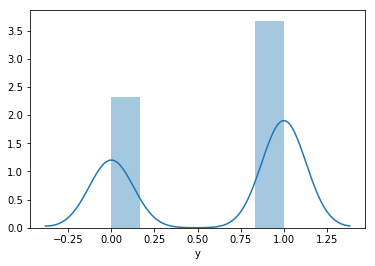

In [83]:
print(target.value_counts())
sns.distplot(target)

Рассмотрим количество признаков с пропущенными данными

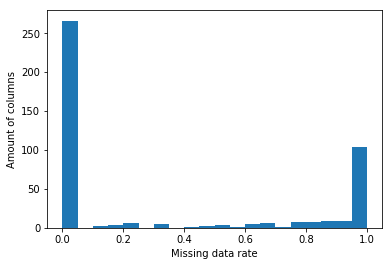

In [130]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

invalid = data.shape[0] - data.count()
missing = invalid[invalid > 0]
missing_fraction = missing / data.shape[0]

plt.hist(missing_fraction, bins=20)
data = data.drop(missing_fraction[missing_fraction > 0.9].index, axis=1)
plt.xlabel("Missing data rate")
plt.ylabel("Amount of columns");

Восполнение данных будет через медиану, так как это более устойчивая характеристика

In [131]:
nunique = data.nunique()
# Выкидываем столбцы в которых только одно значение
data = data.drop(columns=nunique[nunique == 1].index)
nunique = nunique[nunique > 1]

#Разделяем категориальные признаки и вещественные признаки
cat_features = nunique[nunique <= 5].index
num_features = nunique[~nunique.index.isin(cat_features)]


num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

ndata = preprocessor.fit_transform(data)

print(data.shape, ndata.shape)
SI=SimpleImputer(strategy='median')
data_imputed = SI.fit_transform(ndata)
data_imputed.shape

(1095, 1372) (1095, 1615)


(1095, 1615)

In [132]:
median_imputer = SimpleImputer(strategy='median')
data_imputed = median_imputer.fit_transform(ndata)

In [133]:
train_X,test_X,train_y,test_y=train_test_split(data_imputed,target, stratify=target, test_size=0.25, random_state=23,shuffle=True)
train_X.shape,train_y.shape,test_X.shape,test_y.shape

((821, 1615), (821,), (274, 1615), (274,))

Построение модели

для ускорения времени работы были взяты лучшие параметры

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rfc = RandomForestClassifier(n_jobs = 10)

rf_grid = {
    'bootstrap': [False],
    'max_depth': [150],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10],
    'min_samples_split': [2],
    'n_estimators': [100],
    'n_jobs': [4]
}

rsearch_rf = RandomizedSearchCV(rfc,
                                rf_grid,
                                n_iter=10,
                                scoring='roc_auc')

rsearch_rf.fit(train_X, train_y);

C:\Users\SomaC\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\SomaC\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [135]:
rsearch_rf.best_params_, rsearch_rf.best_score_

({'bootstrap': False,
  'max_depth': 150,
  'max_features': 'sqrt',
  'min_samples_leaf': 10,
  'min_samples_split': 2,
  'n_estimators': 100,
  'n_jobs': 4},
 0.8241244028812539)

Тестирование

In [138]:
rsearch_rf.score(test_X,test_y)

0.8629829290206649

In [137]:
def preprocess(test_data):
    test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    test_data = test_data[data.columns.values]
    invalid = data.shape[0] - data.count()
    missing = invalid[invalid > 0]
    missing_fraction = missing / data.shape[0]
    test_data = test_data.drop(missing_fraction[missing_fraction > 0.9].index, axis=1)
    test_data = preprocessor.transform(test_data)
    return median_imputer.transform(test_data)

# Тренеруемся на всём наборе и формируем результат

In [123]:
rsearch_rf.fit(data_imputed,target)

C:\Users\SomaC\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\SomaC\Anaconda3\envs\py27\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=10,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'bootstrap': [False], 'max_depth': [150], 'n_estimators': [100], 'min_samples_leaf': [10], 'n_jobs': [4], 'min_samples_split': [2], 'max_features': ['sqrt']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [96]:
test=pd.read_csv('./input/test.csv')

In [111]:
res=list(zip(test.sample_id,rsearch_rf.predict_proba(preprocess(test))[:,1]))

C:\Users\SomaC\Anaconda3\envs\py27\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [112]:
res=pd.DataFrame(data=res,columns=['sample_id','y'])

In [114]:
res.to_csv('result.csv',index=None)